# Monophonic pitch estimation 

### George Tzanetakis, University of Victoria 

In this notebook we will explore different ways of extracting pitch from monophonic audio 
signals. One synthetic melody example as well as an actual audio recording will be used 
to illustrate the different approaches. 


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal 
from scipy.interpolate import interp1d 

import IPython.display as ipd

First let's create a synthetic simple melody using a sinusoid generation function. 

In [4]:
srate = 22050.0

# generate a discrete time sinusoid signal with a specified amplitude, frequency, duration, and phase 
def sinusoid(freq=440.0, dur=1.0, srate=44100.0, amp=1.0, phase = 0.0): 
    t = np.linspace(0,dur,int(srate*dur))
    data = amp * np.sin(2*np.pi*freq *t+phase)
    return data

# frequencies of three notes (C, D, E) 
c_freq = 523.0   
d_freq = 587.0  
e_freq = 659.0 

# generate sine signals corresponding to each note 
c_data = sinusoid(c_freq, 0.5, srate)
d_data = sinusoid(d_freq, 0.5, srate)
e_data = sinusoid(e_freq, 0.5, srate)

# form a simple melody by concateneting the signal arrays for each note 
melody1 = np.hstack([c_data, d_data, e_data, c_data, c_data, d_data, e_data, c_data])
ipd.Audio(melody1,rate=srate)

In [5]:
srate = 22050.0

# generate a discrete time sinusoid signal with a specified amplitude, frequency, duration, and phase 
def sinusoid(freq=440.0, dur=1.0, srate=44100.0, amp=1.0, phase = 0.0): 
    t = np.linspace(0,dur,int(srate*dur))
    data = amp * np.sin(2*np.pi*freq *t+phase)
    return data

# frequencies of three notes (C, D, E) 
c_freq = 100.0   
d_freq = 102.0  
e_freq = 100.0 

# generate sine signals corresponding to each note 
c_data = sinusoid(c_freq, 0.5, srate)
d_data = sinusoid(d_freq, 0.5, srate)
e_data = sinusoid(e_freq, 0.5, srate)

# form a simple melody by concateneting the signal arrays for each note 
melody1 = np.hstack([c_data, d_data, e_data, c_data, c_data, d_data, e_data, c_data])
ipd.Audio(melody1,rate=srate)

Let's also load an audio recording

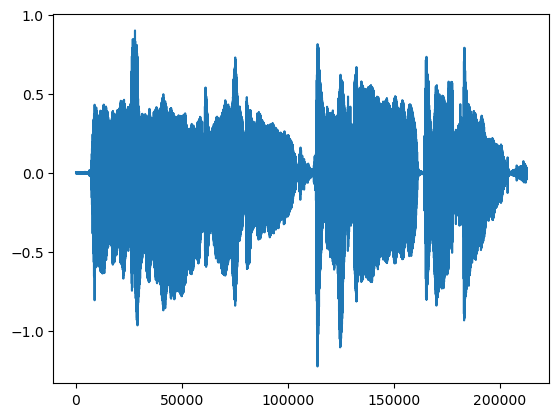

In [6]:
import scipy.io.wavfile as wav
srate, audio_signal = wav.read("amazing_grace_female.wav")
# scale to -1.0/1.0 
melody2 = audio_signal.astype(np.float32) / 32767.0 
# make max be 0.9 
melody2 = (0.9 / max(melody2)) * melody2

plt.figure() 
plt.plot(melody2)
ipd.Audio(melody2,rate=srate)


We will be doing the processing in short chunks of the audio signal. This chunking process is common 
in many digital signal processing algorithms and is characterized by two numbers: the hop size in samples which is the number of samples we advance the start of the chunk in each iteration, and the window size which is the number of samples each chunk (window) will contain. First let's look at a particular chunk (typically called 
a window or a frame) for each input signal (the synthetic sinusoidal melody and the audio recording of Amazing Grace).  

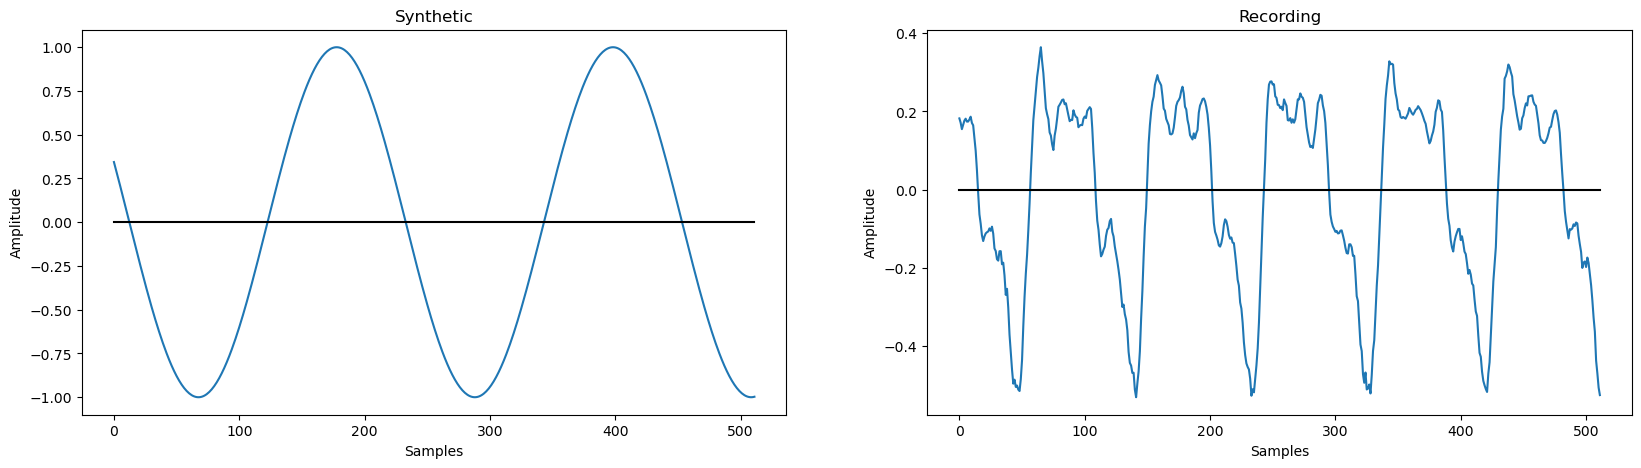

In [7]:
hopSize = 256
winSize = 512

# let's plot the 40th window 
o = 40 * hopSize 
frame1 = melody1[o:o+winSize]
frame2 = melody2[o:o+winSize ]

plt.figure(figsize=(20,5)) 
plt.subplot(121)
plt.title('Synthetic')
plt.plot(frame1)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.plot(np.zeros(len(frame1)), color='black')

plt.subplot(122)
plt.title('Recording')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.plot(frame2)
plt.plot(np.zeros(len(frame2)), color='black')

Let's look at a plot visualizing the short-time processing where the signal is processed in 
overlapping chunks of size window size and advancing by hop size. 

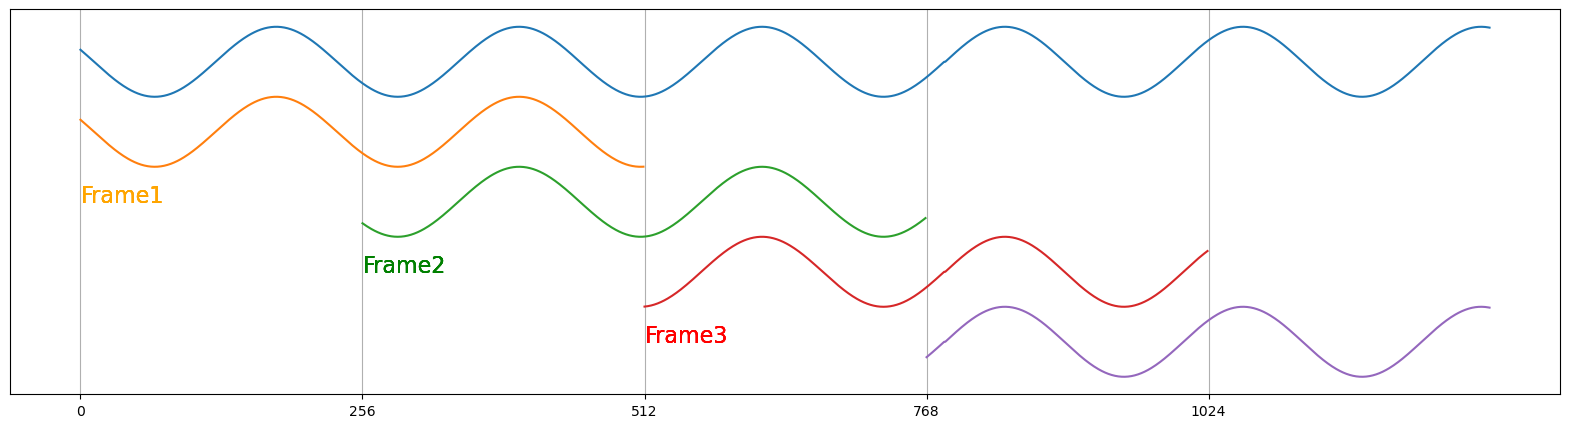

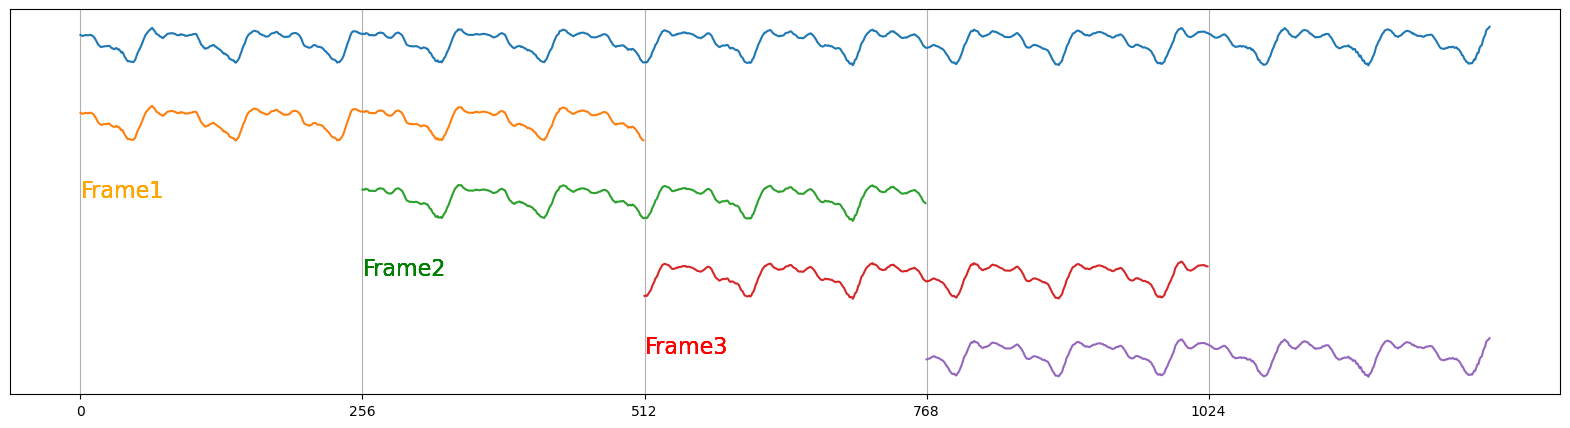

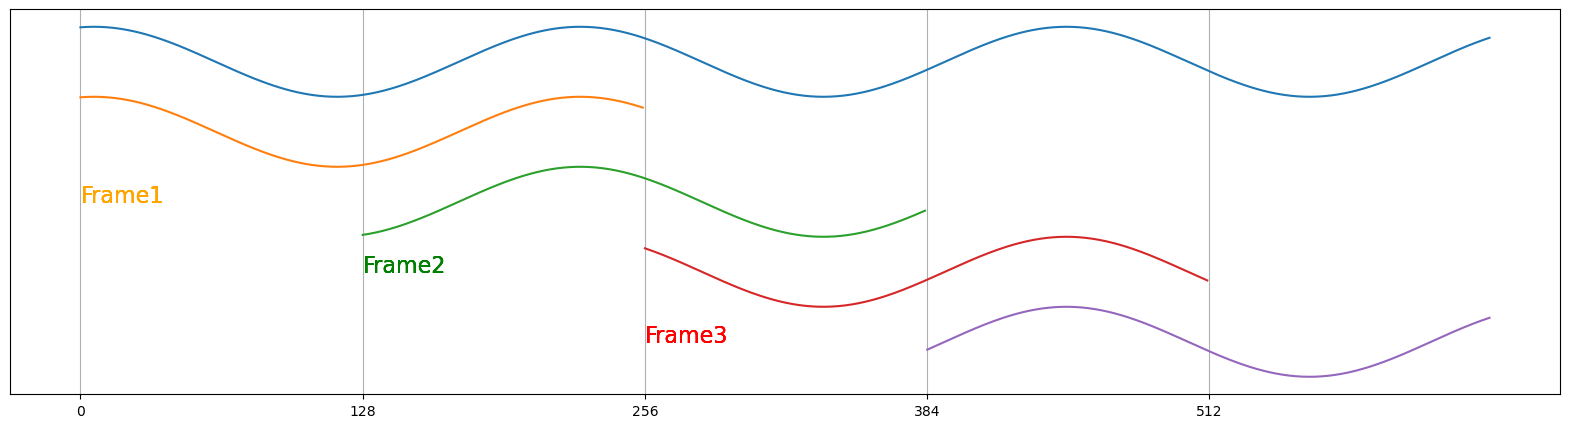

In [8]:
def plot_short_time(signal, hopSize, winSize, start_frame, dur_frames): 
    s  = start_frame
    long_chunk = signal[start_frame * hopSize: (start_frame+ dur_frames) * hopSize]

    plt.figure(figsize=(20,5)) 
    plt.plot(long_chunk)
    
    for m in np.arange(0,4): 
        start = m * hopSize 
        end = m * hopSize + winSize 
        frame = long_chunk[start:end]
        plt.plot(np.arange(start, end), frame - (m+1)* 2.0)
        plt.xticks(np.arange(0, len(long_chunk), step=hopSize))
        plt.text(0, -4, 'Frame1', fontsize=16, color='orange')
        plt.text(hopSize, -6, 'Frame2', fontsize=16, color='green')
        plt.text(2*hopSize, -8, 'Frame3', fontsize=16, color='red')


        plt.yticks([])
        plt.grid(True)

# plot a chunk of the synthetic input as well as the audio recording 
plot_short_time(melody1, 256, 512, 40, 5)
plot_short_time(melody2, 256, 512, 40, 5)

# change the hop size and window size 
plot_short_time(melody1, 128, 256, 40, 5)

Let's look at the zerocrossings for a particular frame and use them to estimate the pitch in Hz for 
that frame. 

Indices: [ 85 306]
Indices diffs: [221]
Mean diff: 221.000000
Pitch estimate in Hz: 99.773756


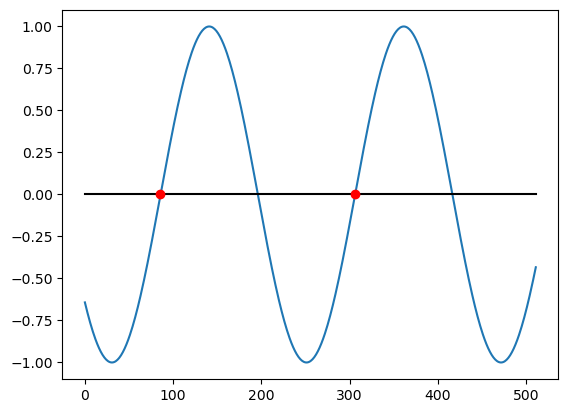

In [9]:
o = 10 * hopSize  
frame = melody1[o:o+winSize] 
zero_line = np.zeros(len(frame))

plt.figure() 
plt.plot(frame)
plt.plot(zero_line, color='black')

# find locations of zerocrossings 
indices = np.nonzero((frame[1:] >= 0) & (frame[:-1] < 0))[0]

# plot them 
plt.plot(indices, zero_line[indices], 'o', color='red')
print("Indices: %s" % np.array2string(indices))

# calculate the difference between successive elements 
print("Indices diffs: %s" % np.array2string(np.diff(indices)))
# take the mean difference - that's the period in samples 
print("Mean diff: %f" % np.mean(np.diff(indices)))
# now compute the pitch estimate 
print("Pitch estimate in Hz: %f" % (srate / np.mean(np.diff(indices))))

Now let's look at doing pitch estimation in the frequency domain by 
examining the magnitude of the Discrete Fourier Transform (DFT) of the frame. 
First we compute the location in frequency bins of the maximum magnitude value 
and then convert that value from frequency bin to frequency in Hz. 

Frequency bin of magnitude peak: 2.000000
Pitch estimate using DFT: 86.132812


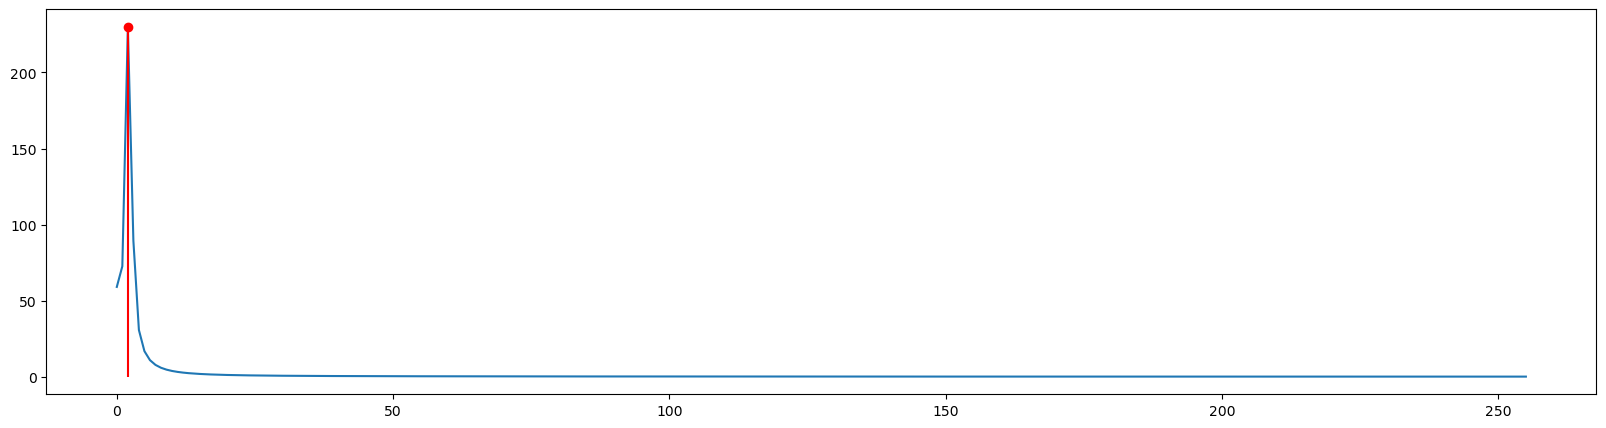

In [10]:
mag = np.abs(np.fft.fft(frame))
mag = mag[0:int(len(mag)/2)]
plt.figure(figsize=(20,5))
plt.plot(mag)
plt.stem([np.argmax(mag)], [np.max(mag)], linefmt='red')
print("Frequency bin of magnitude peak: %f" % np.argmax(mag))
print("Pitch estimate using DFT: %f" % (np.argmax(mag) * (srate / len(frame))))


Now that we have seen how we can estimate the pitch of a single frame of audio 
we can abstract this process into functions and then write a function that 
given an audio signal returns the associated pitch track and amplitude track (RMS) 
using a particular pitch extraction method. 

C:\Users\gtzan\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\gtzan\miniconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


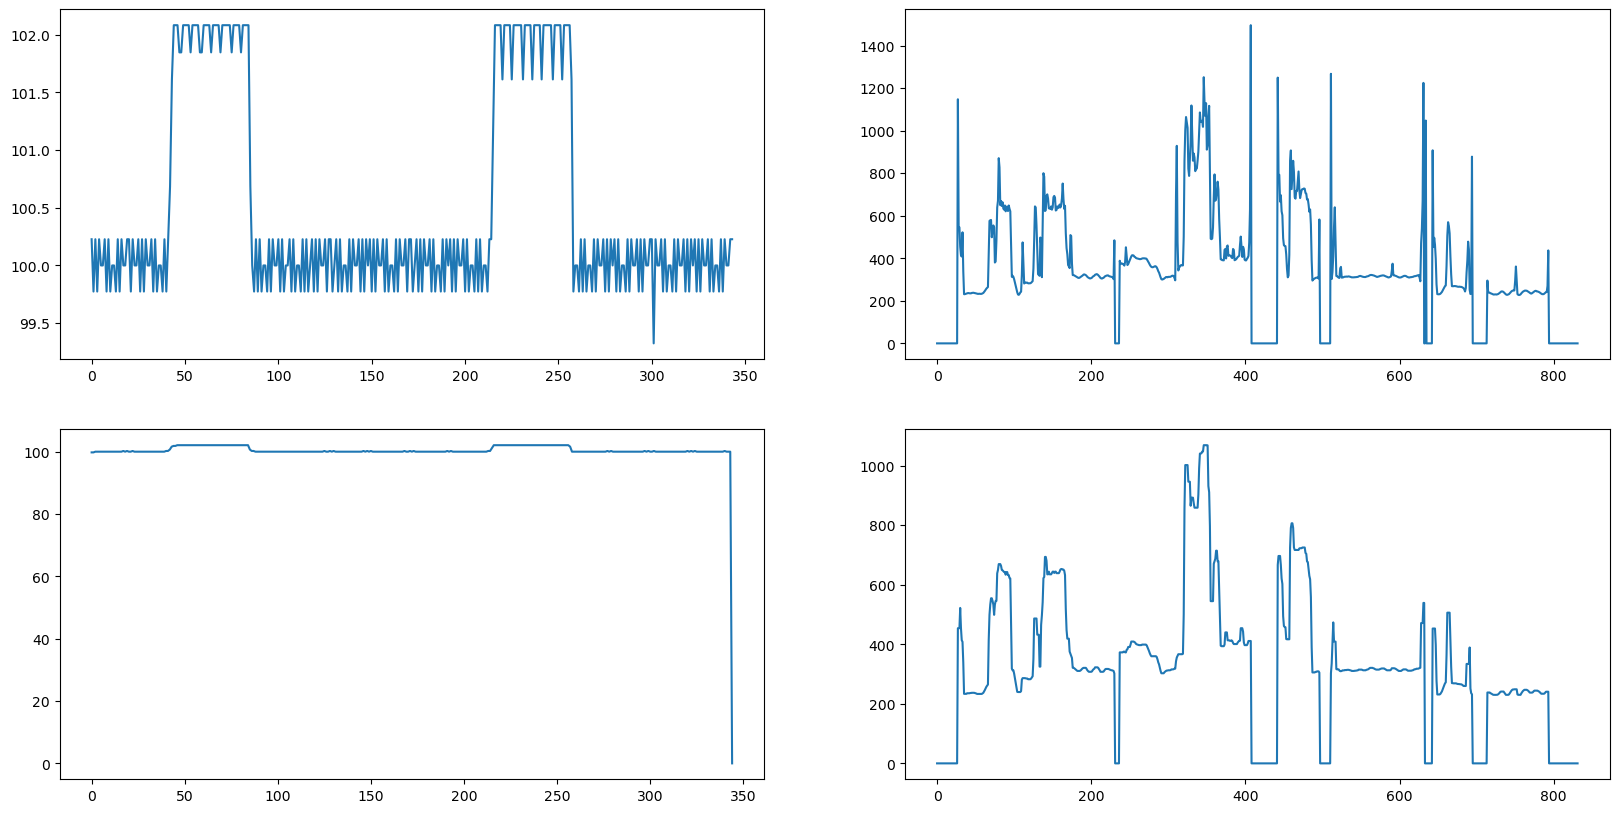

In [11]:

def pitch_zcrs(frame, srate): 
    indices = np.nonzero((frame[1:] >= 0) & (frame[:-1] < 0))[0]
    pitch_estimate = (srate / np.mean(np.diff(indices)))
    return pitch_estimate 

def pitch_fft(frame, srate): 
    mag = np.abs(np.fft.fft(frame))
    mag = mag[0:int(len(mag)/2)]
    pitch_estimate = np.argmax(mag) * (srate / len(frame))
    return pitch_estimate 

def pitch_track(signal, hopSize, winSize, extractor): 
    offsets = np.arange(0, len(signal), hopSize)
    pitch_track = np.zeros(len(offsets))
    amp_track = np.zeros(len(offsets))
    
    for (m,o) in enumerate(offsets): 
        frame = signal[o:o+winSize] 
        pitch_track[m] = extractor(frame, srate)
        amp_track[m] = np.sqrt(np.mean(np.square(frame)))  

        if (pitch_track[m] > 1500): 
            pitch_track[m] = 0 
        
    return (amp_track, pitch_track)
    
# compute the pitch tracks 
(at1, pt1) = pitch_track(melody1, 256, 512, pitch_zcrs)
(at2, pt2) = pitch_track(melody2, 256, 512, pitch_zcrs)

# applying median filtering to smooth the pitch tracks 
pt3 = signal.medfilt(pt1, kernel_size=7)
pt4 = signal.medfilt(pt2, kernel_size=7)


plt.figure(figsize=(20,10)) 
plt.subplot(221)
plt.plot(pt1)
plt.subplot(222)
plt.plot(pt2)
plt.subplot(223)
plt.plot(pt3)
plt.subplot(224)
plt.plot(pt4)
    

The plots provide us some visual indication that our pitch extraction 
process is doing something reasonable but it would be nice to be able 
to hear the generated pitch track. We can achieve this by using a 
sinusoid oscillator that changes instantaneous frequency and amplitude 
with every sample. The sonify function takes as input the amplitude 
and pitch track and return the resulting audio. 

In [12]:
def sonify(amp_track, pitch_track, srate, hop_size):

    times = np.arange(0.0, float(hop_size * len(pitch_track)) / srate,
                      float(hop_size) / srate)

    # sample locations in time (seconds)                                                      
    sample_times = np.linspace(0, np.max(times), int(np.max(times)*srate-1))

    # create linear interpolators for frequencies and amplitudes                              
    # so that we have a frequency and amplitude value for 
    # every sample 
    freq_interpolator = interp1d(times,pitch_track)
    amp_interpolator = interp1d(times,amp_track)

    # use the interpolators to calculate per sample frequency and                             
    # ampitude values                                                                         
    sample_freqs = freq_interpolator(sample_times)
    sample_amps  = amp_interpolator(sample_times)

    # create audio signal                                                                     
    audio = np.zeros(len(sample_times));
    T = 1.0 / srate
    phase = 0.0
    
    # update phase according to the sample frequencies 
    for i in range(1, len(audio)):
        audio[i] = sample_amps[i] * np.sin(phase)
        phase = phase + (2*np.pi*T*sample_freqs[i])

    return audio

pt1_audio = sonify(at1, pt1, srate, hopSize)
ipd.Audio(pt1_audio,rate=srate)


C:\Users\gtzan\miniconda3\Lib\site-packages\IPython\lib\display.py:188: RuntimeWarning: invalid value encountered in cast
  return scaled.astype("<h").tobytes(), nchan


In [13]:
pt2_audio = sonify(at2, pt2, srate, hopSize)
ipd.Audio(pt2_audio,rate=srate)


Using the synthesize function we can also plot and hear the pitch track 
extracted using the DFT-based method. 

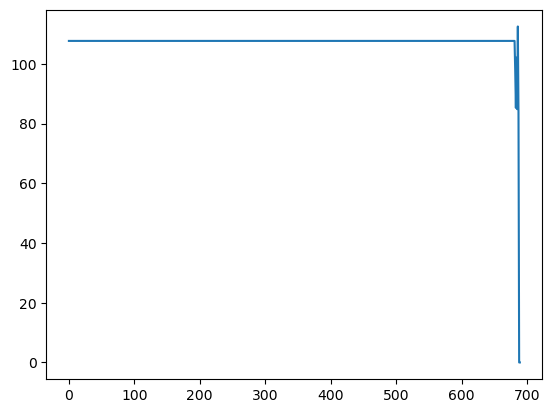

In [14]:
(at1, pt1) = pitch_track(melody1, 128, 1024, pitch_fft)
plt.figure() 
plt.plot(pt1)
plt.show()

In [15]:
pt1_audio = sonify(at1, pt1, srate, 128)
ipd.Audio(pt1_audio,rate=srate)

If we decrease the size of the frame used to compute the DFT our frequency resolution 
will become more coarse i.e each frequency bins will correspond to a larger number 
of Hz. The resulting pitch estimate will not be as accurate and this is something 
one can hear for example if we reduce the window size to 256. 

In [16]:
(at1, pt1) = pitch_track(melody1, 128, 256, pitch_fft)
pt1_audio = sonify(at1, pt1, srate, 128)
ipd.Audio(pt1_audio,rate=srate)

On the other hand if we make the frame much larger then we will start having more than 
one note in a frame and that way we will loose some of the rhythm/time information. 
Hear what happens when the window size is 16384. 

In [17]:
(at1, pt1) = pitch_track(melody1, 128, 16384, pitch_fft)
pt1_audio = sonify(at1, pt1, srate, 128)
ipd.Audio(pt1_audio,rate=srate)

The initial choice of a window size of 1024 with a hop size of 128 seems like a good compromise 
in terms of time and frequency resolution. Let's hear the result of running the DFT-based pitch 
detection on the Amazing Grace recording. 

In [18]:
(at2, pt2) = pitch_track(melody2, 128, 1024, pitch_fft)
pt2_audio = sonify(at2, pt2, srate, 128)
ipd.Audio(pt2_audio,rate=srate)